In [19]:
# ==================
# Library
# ==================
import warnings
warnings.simplefilter('ignore')
import math
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import datetime
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from contextlib import contextmanager
import logging
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import log_loss
import sys
import time
import feather
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import pickle
%matplotlib inline
from sklearn.metrics import average_precision_score

sys.path.append("../src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from util_tool import reduce_mem_usage
pd.set_option('display.max_columns', 300)

In [20]:
# ==================
# Constant
# ==================
ex = "015"
TRAIN_PATH = "../input/train.csv"
TEST_PATH = "../input/test.csv"
USER_PATH = "../input/user_x_anime.csv"
SUB_PATH = "../input/sample_submission.csv"
SAVE_OOF_PATH = f"../output/exp/ex{ex}_oof.npy"
SAVE_TEST_SUB_PATH = f"../output/exp/ex{ex}_test_sub.csv"
LOGGER_PATH = f"../output/exp/ex_{ex}.txt"

In [21]:

# ===============
# Settings
# ===============

SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'verbose_eval': 1000,
}

load_feature = ["../output/fe/fe001.feather",
                "../output/fe/fe002.feather",
                "../output/fe/fe016.feather",
                "../output/fe/fe004.feather",
                "../output/fe/fe005.feather",
                "../output/fe/fe006.feather",
                "../output/fe/fe007.feather",
                "../output/fe/fe009.feather",
                "../output/fe/fe011.feather",
                "../output/fe/fe012.feather",]

In [22]:
# ====================
# Function
# ====================

def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))


@contextmanager
def timer(name):
    t0 = time.time()
    yield 
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')

In [23]:
LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
setup_logger(out_file=LOGGER_PATH)

2021-08-19 21:22:19,260 - INFO - logger set up


<RootLogger root (DEBUG)>

In [24]:
# ====================
# Main
# ====================
train_raw = pd.read_csv(TRAIN_PATH)
y = train_raw["Score"]
df = None
for i in load_feature:
    if df is not None:
        _df = pd.read_feather(i)
        df  = pd.concat([df, _df], axis=1)
    else:
        df = pd.read_feather(i)
train = df.iloc[:len(train_raw)]
test = df.iloc[len(train_raw):].reset_index(drop=True)

In [25]:
with timer("lightgbm"):
    kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
    y_oof = np.empty([len(train),])
    y_test = []
    drop_cols = []
    features = list(train.columns)
    features = [i for i in features if i not in drop_cols]
    feature_importances = pd.DataFrame()
    categorical_features = []
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train,y)):
        print('Fold {}'.format(fold + 1))
        with timer(f"fold {fold}"):
            x_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
            x_val, y_val =train.iloc[valid_idx][features], y.iloc[valid_idx]
            print("train:",len(x_train))

            y_pred_valid, y_pred_test, valid_loss, importances, best_iter,_ = train_lgbm(
                        x_train, y_train, x_val, y_val,test[features],
                        categorical_features=categorical_features,
                        feature_name=features,
                        fold_id=fold,
                        lgb_params=LGBM_PARAMS,
                        fit_params=LGBM_FIT_PARAMS,
                        loss_func=calc_loss,
                        calc_importances=True
                    )

            y_oof[valid_idx] = y_pred_valid
            score = calc_loss(y[valid_idx], y_pred_valid)
            LOGGER.info(f'Fold{fold}:CV={score}')
            y_test.append(y_pred_test)
            feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

    score = calc_loss(y, y_oof)
    np.save(SAVE_OOF_PATH, y_oof)
    LOGGER.info(f'CV={score}')

Fold 1
train: 4000
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.0433125	valid_1's rmse: 0.314116
Early stopping, best iteration is:
[1181]	training's rmse: 0.0349156	valid_1's rmse: 0.31384


2021-08-19 21:22:24,293 - INFO - Fold0:CV=0.3138395343605925
2021-08-19 21:22:24,296 - INFO - [fold 0] done in 5 s


Fold 2
train: 4000
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.0414559	valid_1's rmse: 0.301985
[2000]	training's rmse: 0.0167298	valid_1's rmse: 0.301339
[3000]	training's rmse: 0.0105438	valid_1's rmse: 0.301041
[4000]	training's rmse: 0.0075458	valid_1's rmse: 0.300886
Early stopping, best iteration is:
[4343]	training's rmse: 0.00678838	valid_1's rmse: 0.300826


2021-08-19 21:22:35,699 - INFO - Fold1:CV=0.30082604627689774
2021-08-19 21:22:35,703 - INFO - [fold 1] done in 11 s


Fold 3
train: 4000
Training until validation scores don't improve for 200 rounds


2021-08-19 21:22:38,435 - INFO - Fold2:CV=0.33585164124748135
2021-08-19 21:22:38,440 - INFO - [fold 2] done in 3 s


Early stopping, best iteration is:
[630]	training's rmse: 0.0793156	valid_1's rmse: 0.335852
Fold 4
train: 4000
Training until validation scores don't improve for 200 rounds


2021-08-19 21:22:40,349 - INFO - Fold3:CV=0.32849030695339376
2021-08-19 21:22:40,352 - INFO - [fold 3] done in 2 s


Early stopping, best iteration is:
[385]	training's rmse: 0.122448	valid_1's rmse: 0.32849
Fold 5
train: 4000
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.0418414	valid_1's rmse: 0.333975
Early stopping, best iteration is:
[1765]	training's rmse: 0.0201785	valid_1's rmse: 0.333202


2021-08-19 21:22:46,458 - INFO - Fold4:CV=0.3332019354343257
2021-08-19 21:22:46,461 - INFO - [fold 4] done in 6 s
2021-08-19 21:22:46,467 - INFO - CV=0.32271265854143566
2021-08-19 21:22:46,470 - INFO - [lightgbm] done in 27 s


In [26]:
y_test_sub =  np.mean(y_test,axis=0)
sub = pd.read_csv(SUB_PATH)

In [27]:
sub["Score"] = y_test_sub
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [28]:
feature_importances.groupby(by="feature").mean().sort_values(by="gain",ascending=False).iloc[:20]

,gain,split,fold
feature,,,
anime_id_rate_mean,6172.453671,931.2,2.0
Favorites_Dropped_rate,3195.211586,429.0,2.0
Favorites,2356.710862,124.6,2.0
On-Hold_Dropped_rate,1349.671773,751.4,2.0
On-Hold_Dropped_diff,1035.776808,503.6,2.0
anime_id_emb_16,551.881433,1075.8,2.0
anime_id_emb_18,550.516358,700.8,2.0
Members,469.317833,69.2,2.0
anime_id_emb_13,466.219599,696.8,2.0


(array([0.        , 0.00057143, 0.        , 0.00342857, 0.00628571,
        0.01028571, 0.03828571, 0.13028571, 0.25942857, 0.34457143,
        0.49085714, 0.45542857, 0.41085714, 0.336     , 0.20514286,
        0.09542857, 0.05257143, 0.01714286, 0.00057143, 0.        ]),
 array([2.5 , 2.85, 3.2 , 3.55, 3.9 , 4.25, 4.6 , 4.95, 5.3 , 5.65, 6.  ,
        6.35, 6.7 , 7.05, 7.4 , 7.75, 8.1 , 8.45, 8.8 , 9.15, 9.5 ]),
 <BarContainer object of 20 artists>)

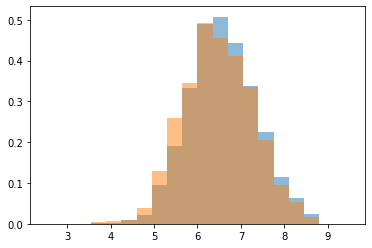

In [29]:
plt.hist(y_test_sub,density=True,range=(2.5,9.5),bins=20,alpha=0.5)
plt.hist(y_oof,density=True,range=(2.5,9.5),bins=20,alpha=0.5)